Libraries import

In [ ]:
import numpy as np
import pandas as pd
import scipy as sci
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from tqdm import tqdm

np.random.seed(1234)
mpl.rcParams['figure.figsize'] = (20, 10)

The following notebook contains some of the code used during the writing of my Master thesis, available on Github at: XXX

# Chapter 1

### 1D Brownian motion

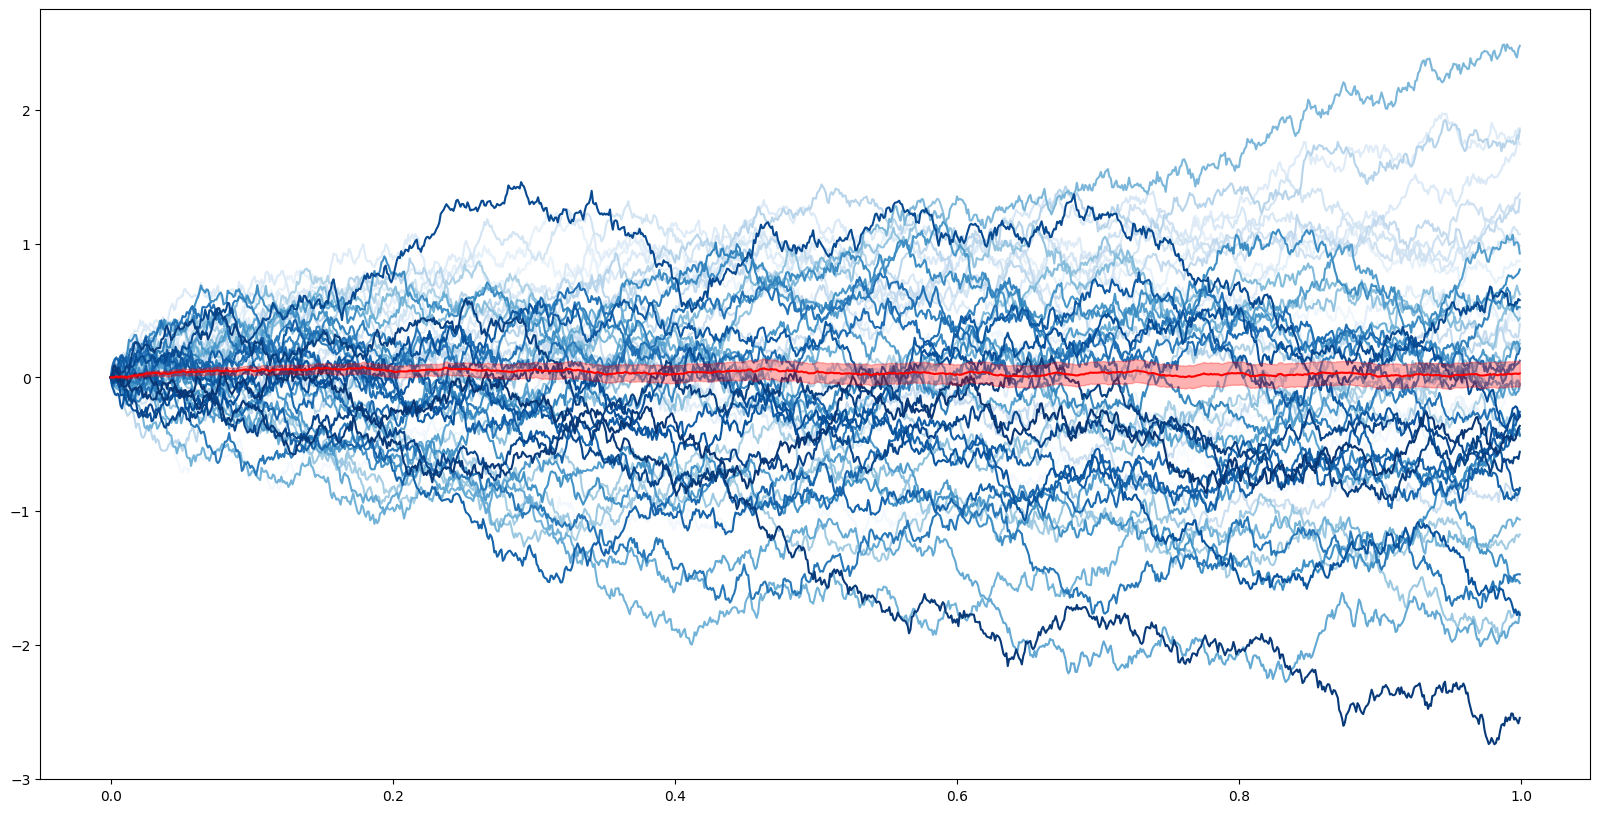

In [28]:
NPATHS = 100
NDRAW = 50
NPOINTS = 1000

t = np.linspace(0, NPOINTS-1, NPOINTS) / NPOINTS
dt = t[1] - t[0]

norm = mpl.colors.Normalize(vmin=1, vmax=NDRAW+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

fig = plt.figure()
ax = fig.add_subplot()

x0 = np.zeros(NPATHS)
x = np.random.normal(size=(NPOINTS - 1, NPATHS)) * np.sqrt(dt)
x = np.cumsum(np.vstack((x0, x)), axis = 0)

mean = np.mean(x, axis=1)
std = np.std(x, axis=1) / np.sqrt(NPATHS)

for i in range(NDRAW):
    ax.plot(t, x[:, i], c=cmap.to_rgba(i+1))
ax.plot(t, mean, c='red')
ax.fill_between(t, mean + std, mean - std, color='r', alpha=0.3, zorder=100)
fig.savefig('plot/1D_BM.pdf')
plt.show()

### 2D Brownian motion

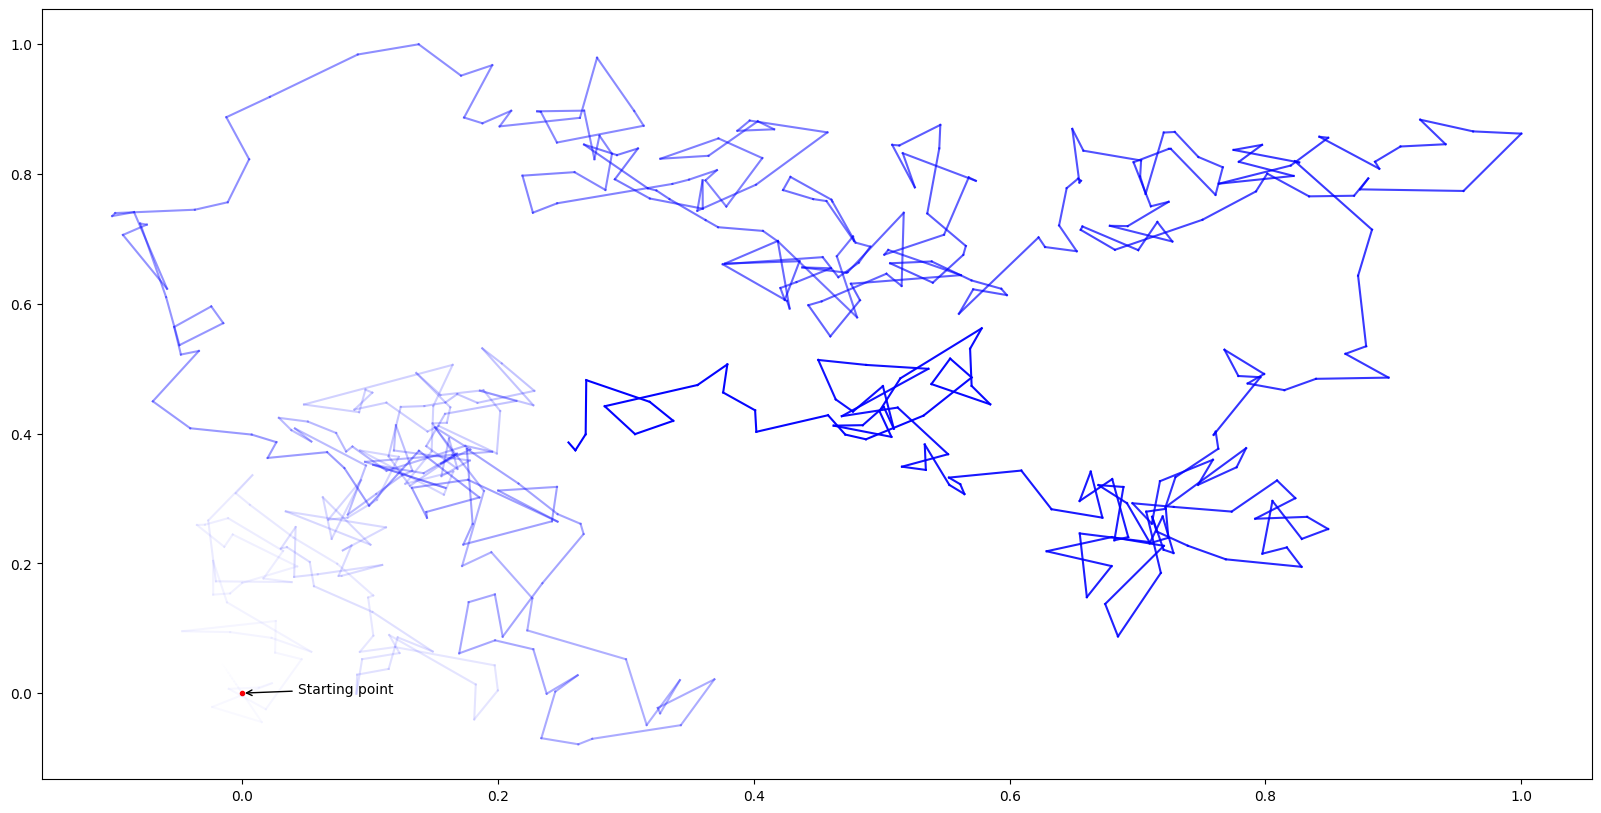

In [54]:
def high_res_points(x, y, factor=10):
    r = [0]
    for i in range(1, len(x)):
        dx = x[i] - x[i-1]
        dy = y[i] - y[i-1]
        r.append(np.sqrt(dx * dx + dy * dy))
    r = np.array(r)
    r_tot = np.cumsum(r)
    dr = r_tot[-1]/(NPOINTS*RES_FACT-1)
    x_mod=[x[0]]
    y_mod=[y[0]]
    r_pos = 0
    rcount = 1 
    while r_pos < r_tot[-1]:
        x1, x2 = x[rcount-1], x[rcount]
        y1, y2 = y[rcount-1], y[rcount]
        d_pos = r_pos - r_tot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        rx = np.sin(theta) * d_pos + x1
        ry = np.cos(theta) * d_pos + y1
        x_mod.append(rx)
        y_mod.append(ry)
        r_pos += dr
        while r_pos > r_tot[rcount]:
            r_pos = r_tot[rcount+1]
            rcount+=1
            if rcount > r_tot[-1]:
                break
    return x_mod, y_mod

NPOINTS = 500
COLOR='blue'
RES_FACT=10

np.random.seed(1234)
x = np.cumsum(np.append(0, np.random.normal(size=NPOINTS - 1)))
y = np.cumsum(np.append(0, np.random.normal(size=NPOINTS - 1)))
x = x / np.max(x)
y = y / np.max(y)

fig = plt.figure()
ax = fig.add_subplot()

x_hi_res,y_hi_res = high_res_points(x, y, RES_FACT)
n_points_hi_res = len(x_hi_res)

ax.plot(0, 0, color='red', marker='.')
for i in range(n_points_hi_res - 1):
    ax.plot(x_hi_res[i:i+2], y_hi_res[i:i+2],
             alpha= float(i) / (n_points_hi_res - 1),
             color= COLOR)

offset = 20
arrow_props = dict(
    arrowstyle="->")
ax.annotate(
    'Starting point',
    (0, 0),
    xytext=(2*offset, 0), textcoords='offset points',
    arrowprops=arrow_props)

fig.savefig('plot/2D_BM.pdf')
plt.show()

## Deterministic vs Stochastic displacement

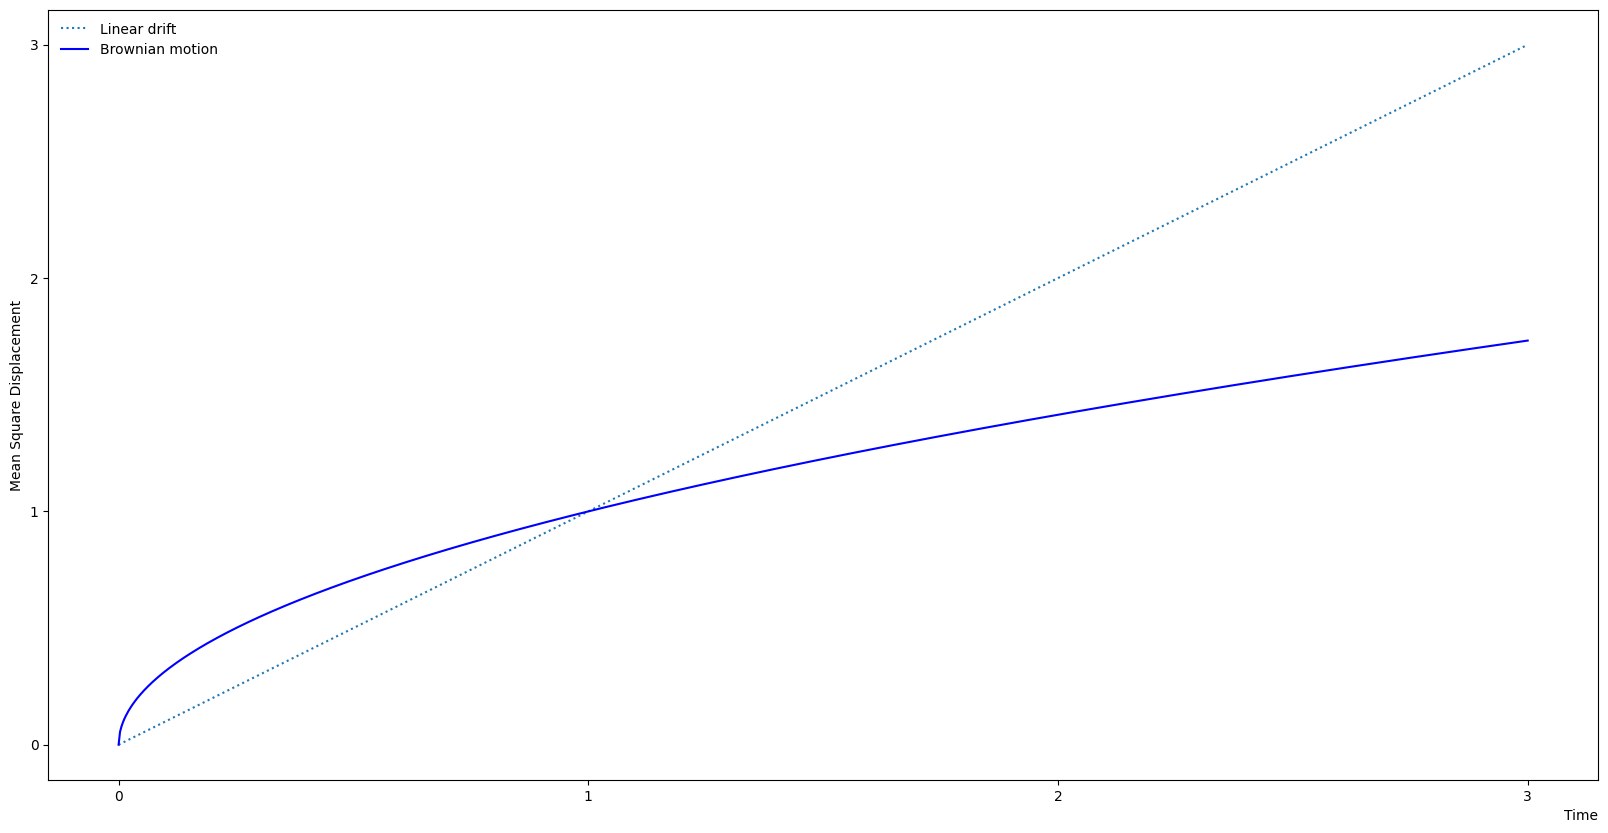

In [30]:
t = np.linspace(0, 3, 1000)
y1 = t
y2 = np.sqrt(t)
fig = plt.figure()
ax = fig.add_subplot()
plt.setp(ax, xticks=[0, 1, 2, 3], yticks=[0, 1, 2, 3])
ax.set_xlabel('Time', loc='right')
ax.set_ylabel('Mean Square Displacement')
ax.plot(t, y1, ls='dotted', label='Linear drift')
ax.plot(t, y2, c='blue', label='Brownian motion')
ax.legend(frameon=False)
fig.savefig('plot/mean_square_disp.pdf')
plt.show()

## 3D Brownian Motion

100%|██████████| 4990/4990 [00:03<00:00, 1393.31it/s]


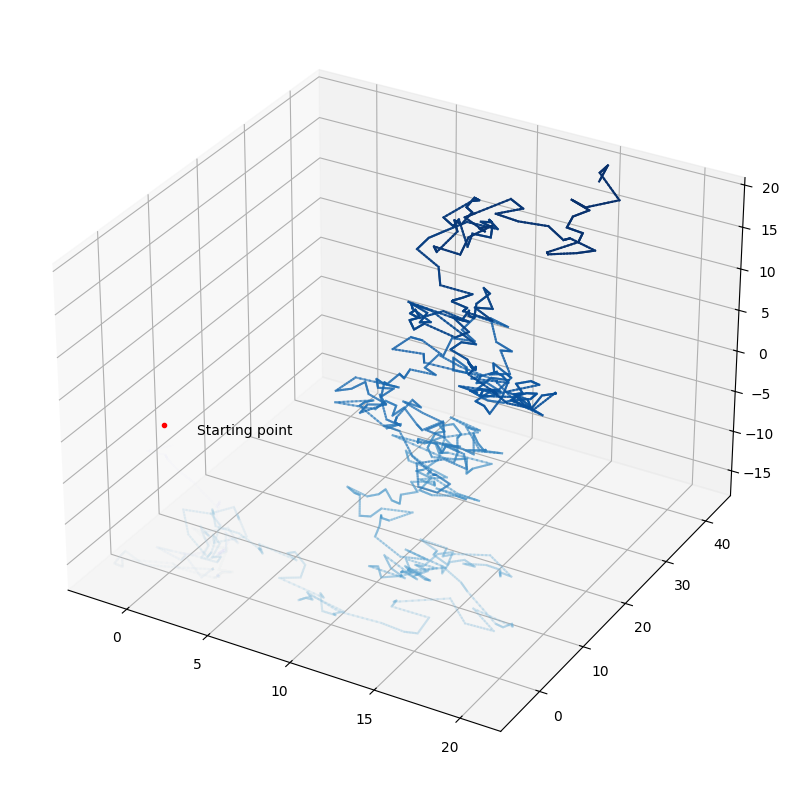

In [31]:
def hig_res_points(x, y, z, FACTOR=10):
    n_points = len(x)
    x_res, y_res, z_res = [], [], []
    t = np.linspace(0, 1, FACTOR)
    for i in range(n_points - 1):
        x2, x1 = x[i+1], x[i]
        y2, y1 = y[i+1], y[i]
        z2, z1 = z[i+1], z[i]
        for ti in t:
            x_res.append(x1 + ti * (x2-x1))
            y_res.append(y1 + ti * (y2-y1))
            z_res.append(z1 + ti * (z2-z1))
    return x_res, y_res, z_res

NPATHS = 3
NPOINTS = 500
COLOR = 'blue'

norm = mpl.colors.PowerNorm(gamma=0.01, vmin=1, vmax=NPOINTS+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

x0 = np.zeros(NPATHS)
x = np.random.normal(size=(NPOINTS - 1, NPATHS))
x = np.cumsum(np.vstack((x0, x)), axis = 0)

x_hi_res, y_hi_res, z_hi_res = hig_res_points(x[:,0],x[:,1],x[:,2])  
n_points_hi_res = len(x_hi_res)

norm = mpl.colors.PowerNorm(gamma=0.5, vmin=1, vmax=n_points_hi_res+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ALPHA_SHIFT = 0.1

for i in tqdm(range(n_points_hi_res)):
    ax.plot3D(x_hi_res[i:i+2], y_hi_res[i:i+2], z_hi_res[i:i+2],
              alpha = float(i + ALPHA_SHIFT) / (n_points_hi_res + ALPHA_SHIFT),
              color = cmap.to_rgba(i))

ax.text(2, 0, 0, 'Starting point')
ax.plot3D(0, 0, 0, color='red', marker='.')
fig.savefig('plot/3D_BM.pdf')
plt.show()

## Diffusion equation

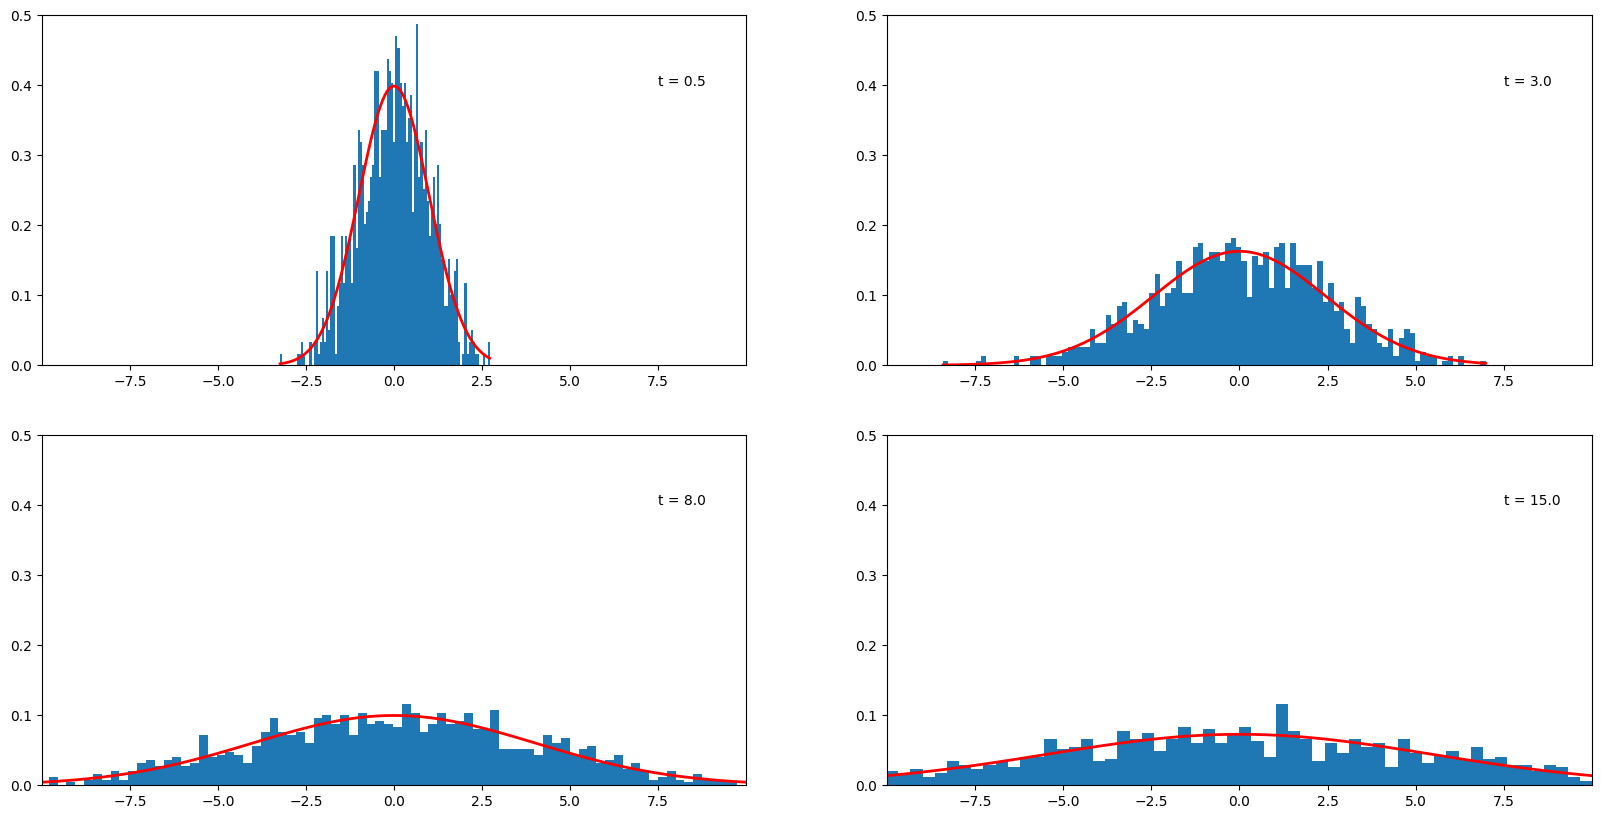

In [32]:
D = 1
T = np.array([0.5, 3, 8, 15])

mu = 0

fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(2, 2)
ax = gs.subplots()

custom_xlim = (-10, 10)
custom_ylim = (0, 0.5)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(ax, xticks=[-7.5, -5, -2.5, 0, 2.5, 5, 7.5])

t = T[0]
sigma = np.sqrt(2 * D * t)
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = ax[0, 0].hist(s, 100, density=True)
ax[0, 0].plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)),linewidth=2, color='r')
ax[0, 0].text(7.5, 0.4, "t = " + str(t))

t = T[1]
sigma = np.sqrt(2 * D * t)
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = ax[0, 1].hist(s, 100, density=True)
ax[0, 1].plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)),linewidth=2, color='r')
ax[0, 1].text(7.5, 0.4, "t = " + str(t))

t = T[2]
sigma = np.sqrt(2 * D * t)
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = ax[1, 0].hist(s, 100, density=True)
ax[1, 0].plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)),linewidth=2, color='r')
ax[1, 0].text(7.5, 0.4, "t = " + str(t))

t = T[3]
sigma = np.sqrt(2 * D * t)
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = ax[1, 1].hist(s, 100, density=True)
ax[1, 1].plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)),linewidth=2, color='r')
ax[1, 1].text(7.5, 0.4, "t = " + str(t))

plt.savefig('plot/heat_equation.pdf')
plt.show()

## Geometric Brownian Motion

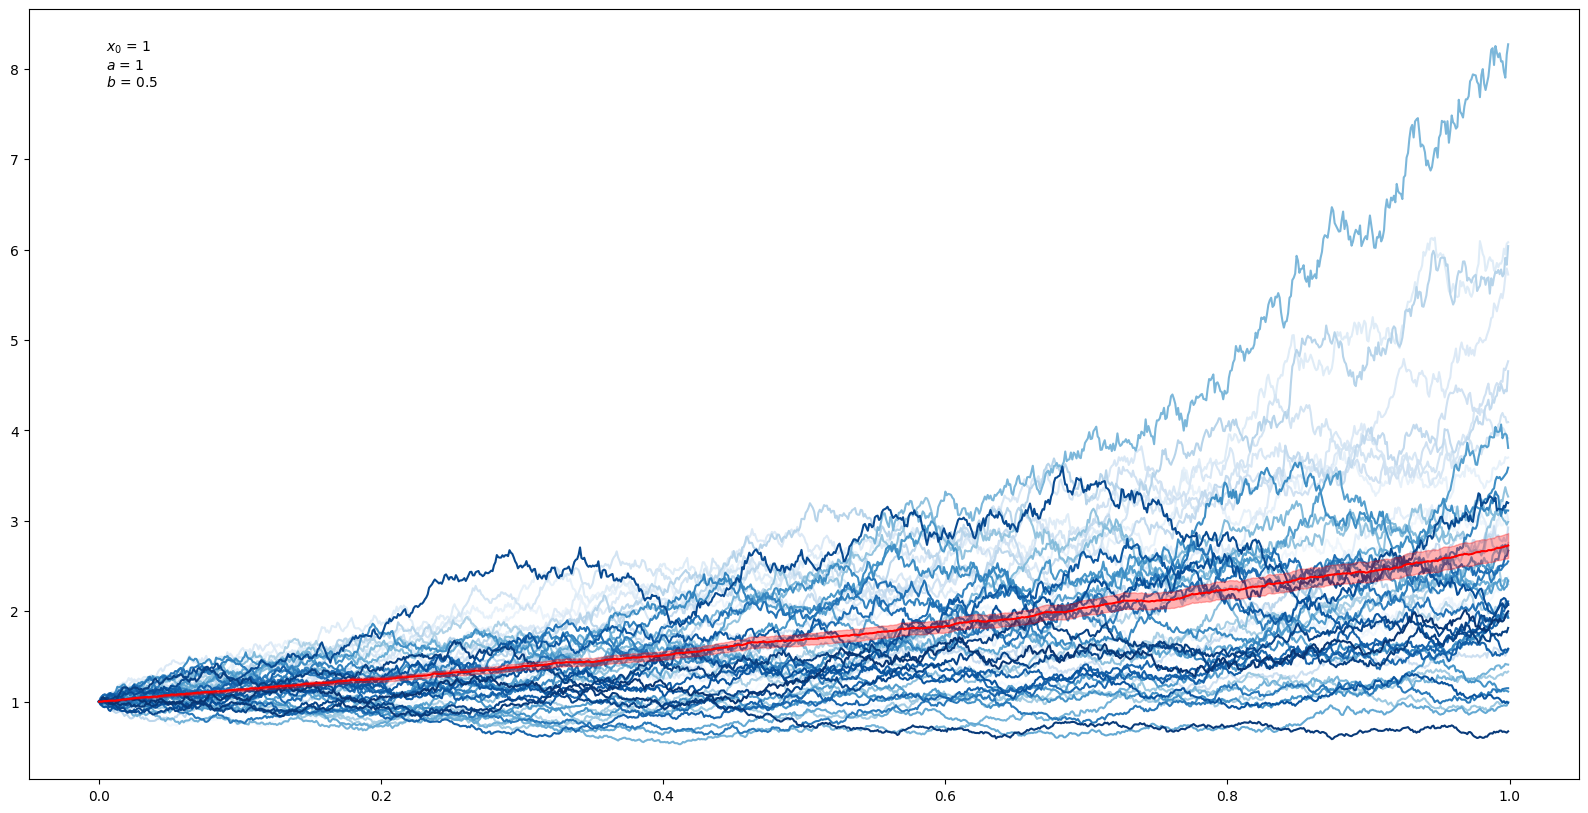

In [33]:
NPOINTS = 1000
NPATH = 100
NDRAW = 50
np.random.seed(1234)
norm = mpl.colors.Normalize(vmin=1, vmax=NDRAW+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

x0 = 1
a = 1
b = 0.5

t = np.linspace(0,NPOINTS-1,NPOINTS) / NPOINTS
dt = t[1] - t[0]

fig = plt.figure()
ax = fig.add_subplot()

w = np.concatenate((np.zeros((1, NPATH)), np.random.normal(size=(NPOINTS - 1, NPATH)) * np.sqrt(dt)), axis=0)
w = np.cumsum(w, axis=0)
x = x0 * np.exp((a - 0.5 * b ** 2) * t.reshape(-1, 1) + b * w)
mean_value = np.mean(x, axis=1)
st_dev = np.std(x, axis=1)/np.sqrt(NPATH)

for i in range(NDRAW):
    ax.plot(t, x[:, i], color= cmap.to_rgba(i + 1))
ax.plot(t, mean_value, color= 'red')
ax.fill_between(t, mean_value + st_dev, mean_value - st_dev, color= 'r', zorder=100, alpha=0.3)
ax.text(0.05, 0.9, f"$x_0$ = {x0} \n$a$ = {a}\n$b$ = {b}", transform=ax.transAxes)
fig.savefig('plot/1D_GBM.pdf')
plt.show()

## Ornstein-Uhlenbeck process

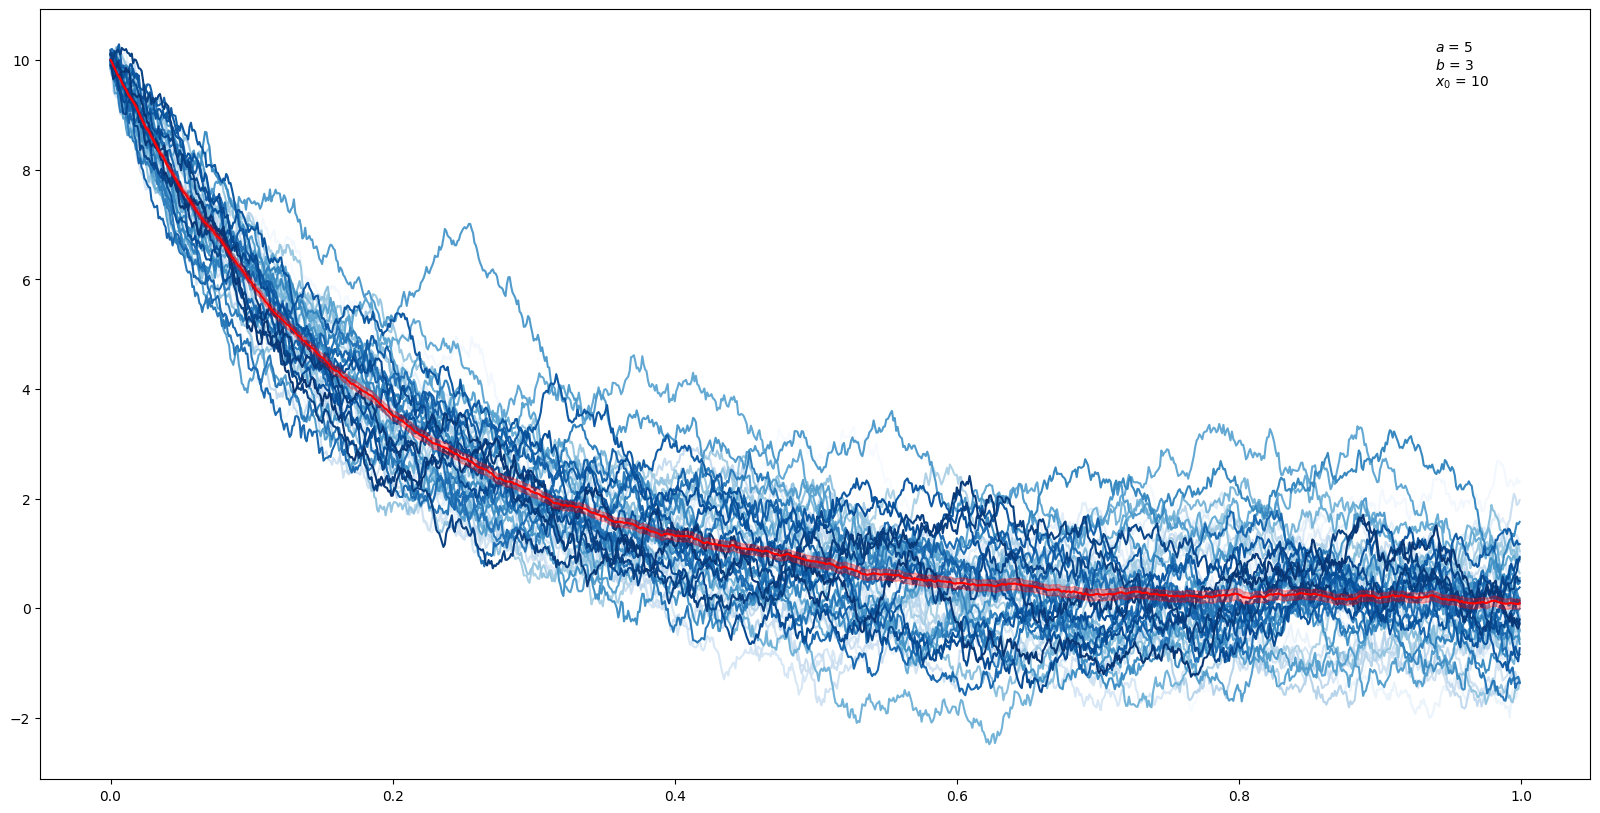

In [34]:
NPOINTS = 1000
NPATH = 100
NDRAW = 50

a = 5
b = 3
x0 = 10

fig = plt.figure()
ax = fig.add_subplot()

norm = mpl.colors.Normalize(vmin=1, vmax=NDRAW+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

t = np.linspace(0, NPOINTS-1, NPOINTS) / NPOINTS
dt = t[1] - t[0]

dw = np.random.normal(size = (NPOINTS, NPATH)) * np.sqrt(dt) 
integrand = np.exp(a * t).reshape(-1, 1) * dw
integral = np.cumsum(integrand, axis = 0)
x = (x0 + b * integral) * np.exp(- a * t).reshape(-1, 1)

for i in range(NDRAW):
    ax.plot(t, x[:, i], c = cmap.to_rgba(i + 1))

st_dev = np.std(x, axis = 1) / np.sqrt(NPATH)

mean_value = np.mean(x, axis = 1)
ax.plot(t, mean_value, c='red')
ax.fill_between(t,  mean_value + st_dev, mean_value - st_dev, color= 'r', zorder=100, alpha=0.3)
ax.text(0.9, 0.9, f"$a$ = {a}\n$b$ = {b}\n$x_0$ = {x0}", transform=ax.transAxes)
fig.savefig('plot/OU.pdf')
plt.show()

# Chapter 2

## Forward curve construction

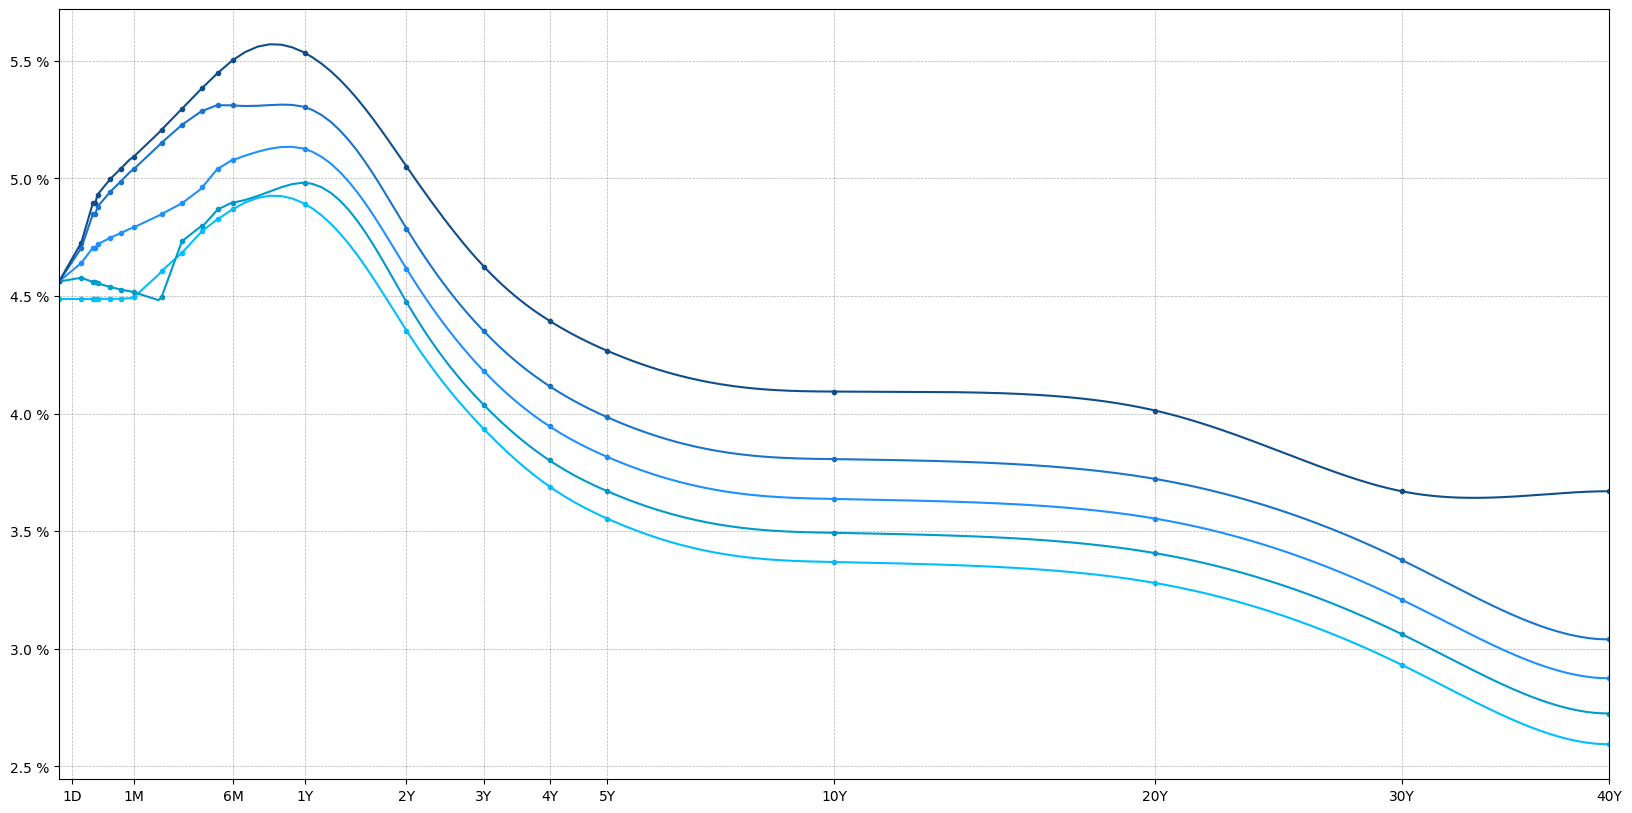

In [35]:
COLOR= ['#00BFFF', '#009ACD', '#1E90FF', '#1874CD', '#104E8B']

dates = ['0D','1D', '2D', '3D', '1W', '2W', '3W', '1M', '2M', '3M', '4M', '5M',
         '6M', '1Y', '2Y', '3Y', '4Y', '5Y', '10Y', '20Y', '30Y', '40Y']

dates_long = np.array([44915, 44918, 44922, 44923, 44924, 44931, 44938, 44949, 44979, 45007, 45040,
              45068, 45099, 45282, 45649, 46013, 46378, 46743, 48570, 52222, 55876, 59527]) - 44915

OIS_libor = [4.4877, 4.4874, 4.4878, 4.4878, 4.4879, 4.4882, 4.4884, 4.4950, 4.6065, 4.6843, 4.7773,
             4.8267, 4.8699, 4.8918, 4.3530, 3.9337, 3.6900, 3.5536, 3.3691, 3.2799, 2.9323, 2.5942]

ONEM_libor = [4.5618, 4.5778, 4.5594, 4.5594, 4.5537, 4.5385, 4.5274, 4.5163, 4.4965, 4.7334, 4.7958,
              4.8679, 4.8970, 4.9815, 4.4744, 4.0361, 3.8010, 3.6701, 3.4932, 3.4068, 3.0628, 2.7249]

THREEM_libor = [4.5618, 4.6407, 4.7062, 4.7062, 4.7197, 4.7480, 4.7672, 4.7919, 4.8486, 4.8946, 4.9636,
                5.0407, 5.0786, 5.1253, 4.6159, 4.1800, 3.9459, 3.8160, 3.6372, 3.5538, 3.2094, 2.8747]

SIXM_libor = [4.5618, 4.7041, 4.8497, 4.8497, 4.8801, 4.9438, 4.9863, 5.0399, 5.1522, 5.2283, 5.2871,
              5.3111, 5.3101, 5.3032, 4.7871, 4.3497, 4.1166, 3.9846, 3.8065, 3.7224, 3.3781, 3.0398]

ONEY_libor = [4.5618, 4.7271, 4.8975, 4.8975, 4.9312, 4.9982, 5.0406, 5.0930, 5.2076, 5.2968, 5.3857,
              5.4481, 5.5036, 5.5339, 5.0507, 4.6248, 4.3945, 4.2671, 4.0938, 4.0131, 3.6701, 3.6701]

dates_eq_spaced = [dates_long[0] + 30 * i for i in range(int(dates[-1][:-1])*12 + 1)]
x = np.append(dates_long, dates_eq_spaced)
x = np.unique(x)

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(dates_long, OIS_libor, c=COLOR[0], marker = '.')
OIS_libor = sci.interpolate.CubicSpline(dates_long, OIS_libor, bc_type='clamped')
ax.plot(x, OIS_libor(x), label='OIS', c=COLOR[0])

ax.scatter(dates_long, ONEM_libor, c=COLOR[1], marker = '.')
ONEM_libor = sci.interpolate.CubicSpline(dates_long, ONEM_libor, bc_type='clamped')
ax.plot(x, ONEM_libor(x), label='1M', c=COLOR[1])

ax.scatter(dates_long, THREEM_libor, c=COLOR[2], marker = '.')
THREEM_libor = sci.interpolate.CubicSpline(dates_long, THREEM_libor, bc_type='clamped')
ax.plot(x, THREEM_libor(x), label='3M', c=COLOR[2])

ax.scatter(dates_long, SIXM_libor, c=COLOR[3], marker = '.')
SIXM_libor = sci.interpolate.CubicSpline(dates_long, SIXM_libor, bc_type='clamped')
ax.plot(x, SIXM_libor(x), label='6M', c=COLOR[3])

ax.scatter(dates_long, ONEY_libor, c=COLOR[4], marker = '.')
ONEY_libor = sci.interpolate.CubicSpline(dates_long, ONEY_libor, bc_type='clamped')
ax.plot(x, ONEY_libor(x), label='1Y', c=COLOR[4])

ax.set_xscale('function', functions=(lambda x: x**(1/2), lambda x: x**2))
ax.set_xticks([1, 34, 184, 367, 734, 1098, 1463, 1828, 3655, 7307, 10961, 14612])
ax.set_xticklabels(['1D', '1M', '6M', '1Y', '2Y', '3Y', '4Y', '5Y', '10Y', '20Y', '30Y', '40Y'])

y_ticks = [i * 0.5 for i in range(12)]
y_ticks_label = [f"{a} %" for a in y_ticks]
ax.set_yticks(y_ticks, y_ticks_label, minor=False)

ax.grid(True, 'both', ls='--', lw=.5, c='k', alpha=.3)
ax.margins(0, 0.05)
fig.savefig('plot/USDLIBOR_CURVE.pdf')
plt.show()

## Lognormal process

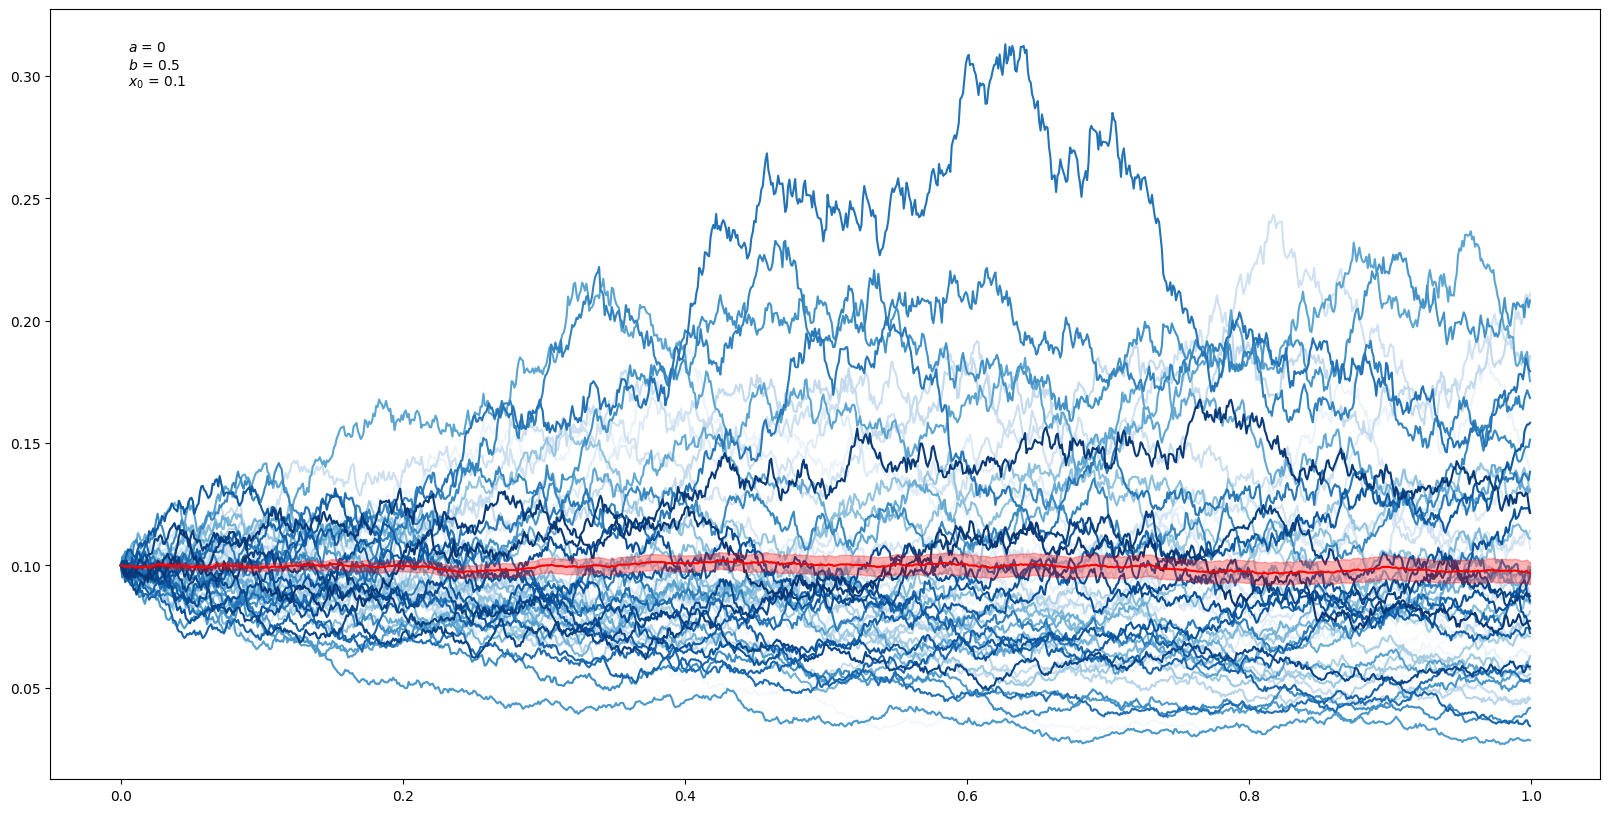

In [36]:
NPOINTS = 1000
NPATH = 100
NDRAW = 50
np.random.seed(1235)
norm = mpl.colors.Normalize(vmin=1, vmax=NDRAW+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

x0 = 0.1
a = 0
b = 0.5

t = np.linspace(0,NPOINTS-1,NPOINTS) / NPOINTS
dt = t[1] - t[0]

fig = plt.figure()
ax = fig.add_subplot()

w = np.concatenate((np.zeros((1, NPATH)), np.random.normal(size=(NPOINTS - 1, NPATH)) * np.sqrt(dt)), axis=0)
w = np.cumsum(w, axis=0)
x = x0 * np.exp((a - 0.5 * b ** 2) * t.reshape(-1, 1) + b * w)
mean_value = np.mean(x, axis=1)
st_dev = np.std(x, axis=1) / np.sqrt(NPATH)

for i in range(NDRAW):
    ax.plot(t, x[:, i], color= cmap.to_rgba(i + 1))
ax.plot(t, mean_value, color= 'red')
ax.fill_between(t, mean_value + st_dev, mean_value - st_dev, color= 'r', alpha=0.3, zorder=100)
ax.text(0.05, 0.9, f"$a$ = {a}\n$b$ = {b}\n$x_0$ = {x0}", transform=ax.transAxes)
fig.savefig('plot/LOGNORMAL.pdf')
plt.show()

## USD1MFSR

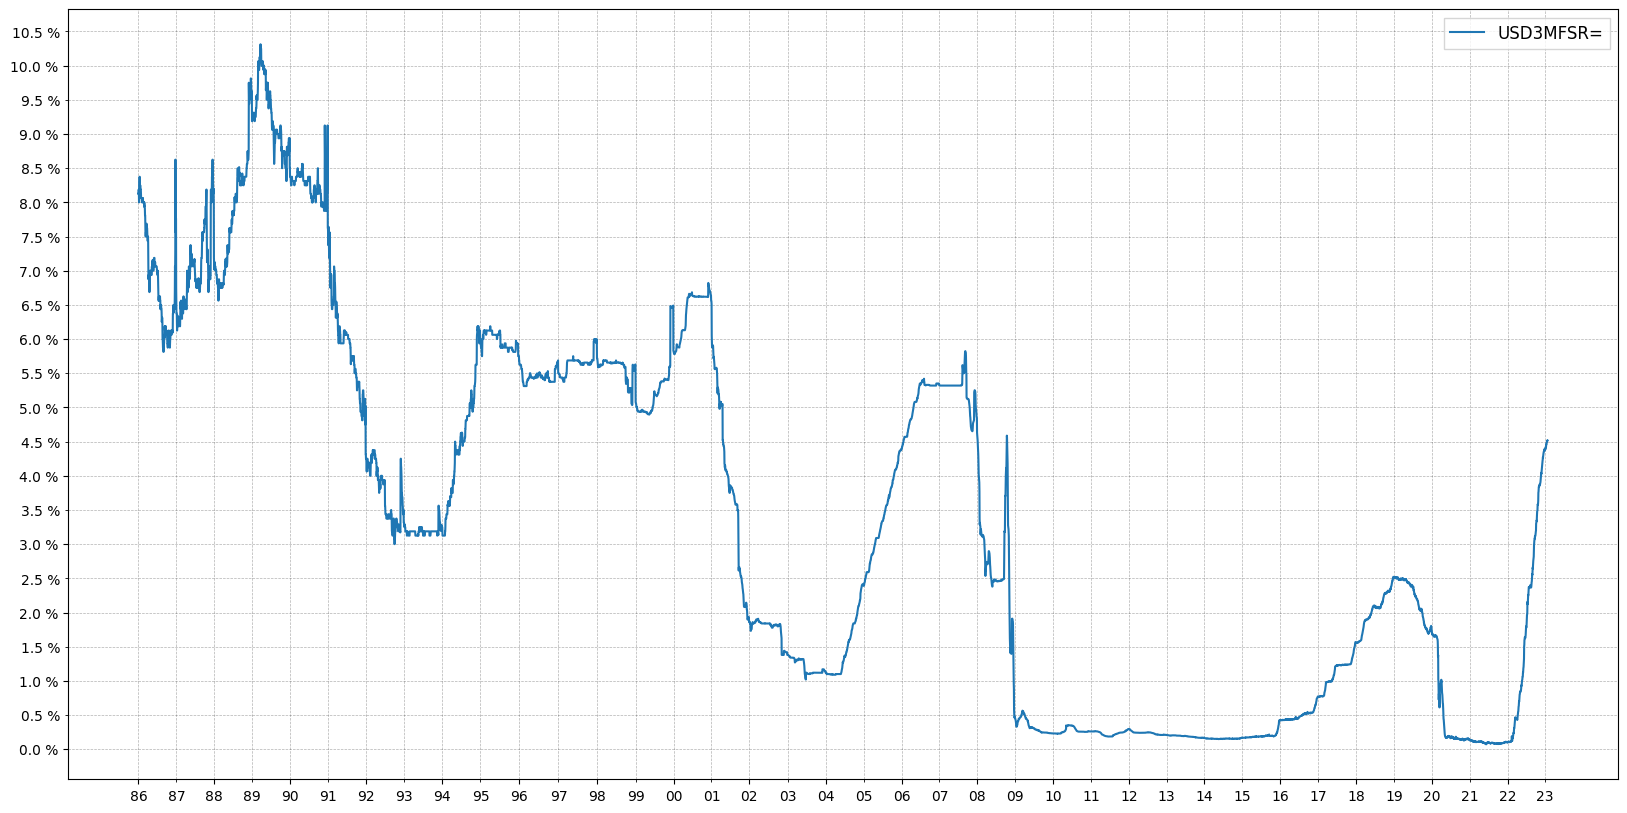

In [38]:
df = pd.read_csv('data/USD1MFSR.csv', parse_dates=['Date']) 
date = df['Date'].to_numpy()
rate = df['Open'].to_numpy()

date_years = date.astype('datetime64[Y]')
labels_index = np.where(np.append(1,np.where(date_years[1:] == date_years[:-1], 0, 1)) == 1)[0]
labels = [("%.f" % a).zfill(2) for a in np.append(np.arange(86, 99+1, 1), np.arange(0, 23+1, 1))]

fig = plt.figure()
ax = fig.add_subplot()

ax.set_xticks(labels_index[::2], labels[::2], minor=False)
ax.set_xticks(labels_index[1::2], labels[1::2], minor=True)
ax.get_xaxis().set_tick_params(which='minor', pad=5)

ax.grid(True, 'both', ls='--', lw=.5, c='k', alpha=.3)
yticks = [i * 0.5 for i in range(22)]
yticks_label = [f"{a} %" for a in yticks]

ax.set_yticks(yticks[::2], yticks_label[::2], minor=False)
ax.set_yticks(yticks[1::2], yticks_label[1::2], minor=True)

l = ax.plot(rate, label="USD3MFSR=")
leg = ax.legend(fontsize='large',
                fancybox=False)

fig.savefig('plot/USD1MFSR.pdf')
plt.show()

 ## Swap implied volatility surface

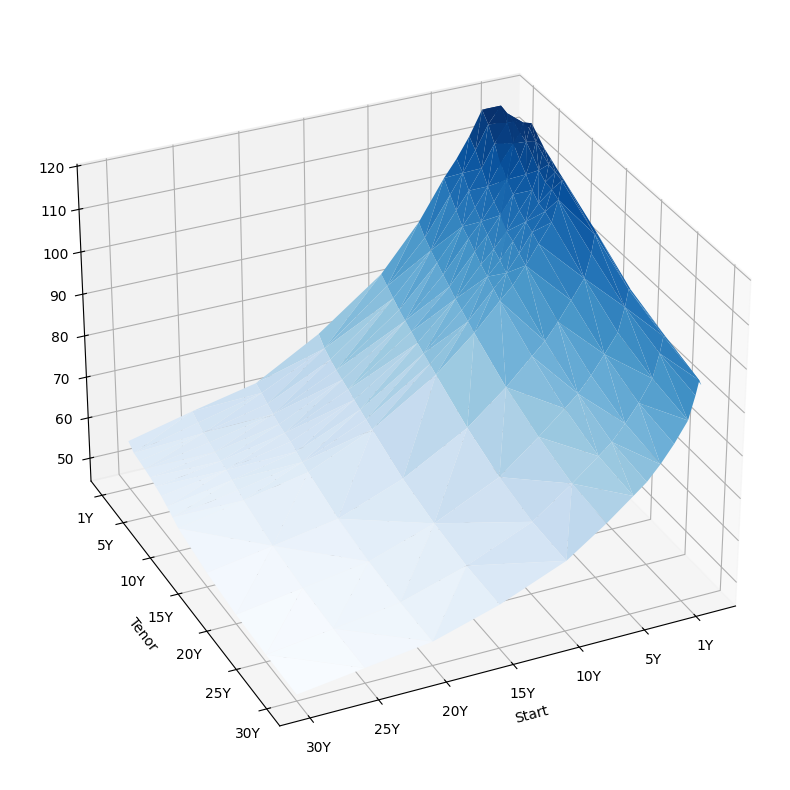

In [45]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

df = pd.read_csv('data/SWPVOLA.csv')
start_s = df['Start'].values
tenor_s = df.columns[1:].values
vola = df.values[:, 1:]

start = np.array([float(s[:-1]) for s in start_s])
for i in (0,1,2):
    start[i]/=12
tenor = np.array([float(t[:-1]) for t in tenor_s])
X, Y = [],[]
for s in start:
    for t in tenor:
        X.append(s)
        Y.append(t)
ax.plot_trisurf(X, Y, vola.reshape(-1).astype('float'), cmap=mpl.cm.Blues)

ax.set_xlabel("Start")
ax.set_ylabel("Tenor")
ax.view_init(30, 65)

tick = np.append([1], [i*5 for i in range(1,7)])
label = [f"{t}Y" for t in tick]
ax.set_xticks(tick, label)
ax.set_yticks(tick, label)
fig.savefig('plot/SWP_VOLATILITY.pdf')
plt.show()

## Cap implied volatility

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

ref = 44987
expiry = [45079, 45173, 45264, 45355, 45446, 45537, 45628, 45719, 45810, 45902, 45993, 46083, 46175, 46267, 46358, 46448,
          46540, 46632, 46723, 46814, 46906, 47000, 47091, 47179, 47273, 47364, 47455, 47546, 47637, 47728, 47819, 47910,
          48001, 48093, 48184, 48275, 48367, 48459, 48550, 48640, 48732, 48824, 48915, 49005, 49097, 49191, 49282, 49370,
          49464, 49555, 49646, 49737, 49828, 49920, 50011, 50101, 50193, 50285, 50376, 50466, 50558, 50650, 50741, 50831,
          50923, 51015, 51106, 51197, 51291, 51382, 51473, 51564, 51655, 51746, 51837, 51928, 52019, 52111, 52202, 52292,
          52384, 52476, 52567, 52658, 52750, 52842, 52933, 53023, 53115, 53209, 53300, 53388, 53482, 53573, 53664, 53755,
          53846, 53937, 54028, 54119, 54211, 54303, 54394, 54484, 54576, 54668, 54759, 54849, 54941, 55033, 55124, 55214,
          55306, 55400, 55491, 55582, 55673, 55764, 55855]
expiry = np.array(expiry) - ref
vola = [0.2199, 0.2018, 0.2122, 0.2628, 0.3444, 0.4239, 0.4824, 0.4869, 0.4500, 0.3986, 0.3605, 0.3565, 0.3785, 0.4091,
        0.4286, 0.4225, 0.3980, 0.3686, 0.3474, 0.3433, 0.3515, 0.3637, 0.3698, 0.3640, 0.3487, 0.3315, 0.3183, 0.3137,
        0.3159, 0.3213, 0.3260, 0.3271, 0.3251, 0.3217, 0.3186, 0.3171, 0.3171, 0.3178, 0.3184, 0.3183, 0.3177, 0.3169,
        0.3160, 0.3150, 0.3136, 0.3116, 0.3095, 0.3073, 0.3054, 0.3039, 0.3029, 0.3022, 0.3019, 0.3020, 0.3025, 0.3033,
        0.3045, 0.3060, 0.3078, 0.3099, 0.3121, 0.3142, 0.3162, 0.3181, 0.3199, 0.3216, 0.3233, 0.3249, 0.3263, 0.3277,
        0.3290, 0.3302, 0.3312, 0.3322, 0.3331, 0.3340, 0.3347, 0.3353, 0.3358, 0.3363, 0.3369, 0.3377, 0.3387, 0.3399,
        0.3412, 0.3428, 0.3444, 0.3463, 0.3484, 0.3507, 0.3532, 0.3558, 0.3587, 0.3618, 0.3651, 0.3686, 0.3723, 0.3763,
        0.3805, 0.3849, 0.3895, 0.3942, 0.3988, 0.4035, 0.4083, 0.4132, 0.4180, 0.4228, 0.4277, 0.4325, 0.4372, 0.4419,
        0.4465, 0.4511, 0.4555, 0.4597, 0.4637, 0.4676, 0.4711]

ax.plot(expiry[:61], vola[:61], marker='.', label="EUR ESTR OIS")

ax.set_xticks(expiry[:61:4], [f'{i}Y' for i in range(0,16)])

leg = ax.legend(fontsize='large',
                fancybox=False)

ax.grid(True, 'both', ls='--', lw=.5, c='k', alpha=.3)
fig.savefig('plot/CAP_VOLATILITY.pdf')
plt.show()

# Chapter 3

## Vasicek model

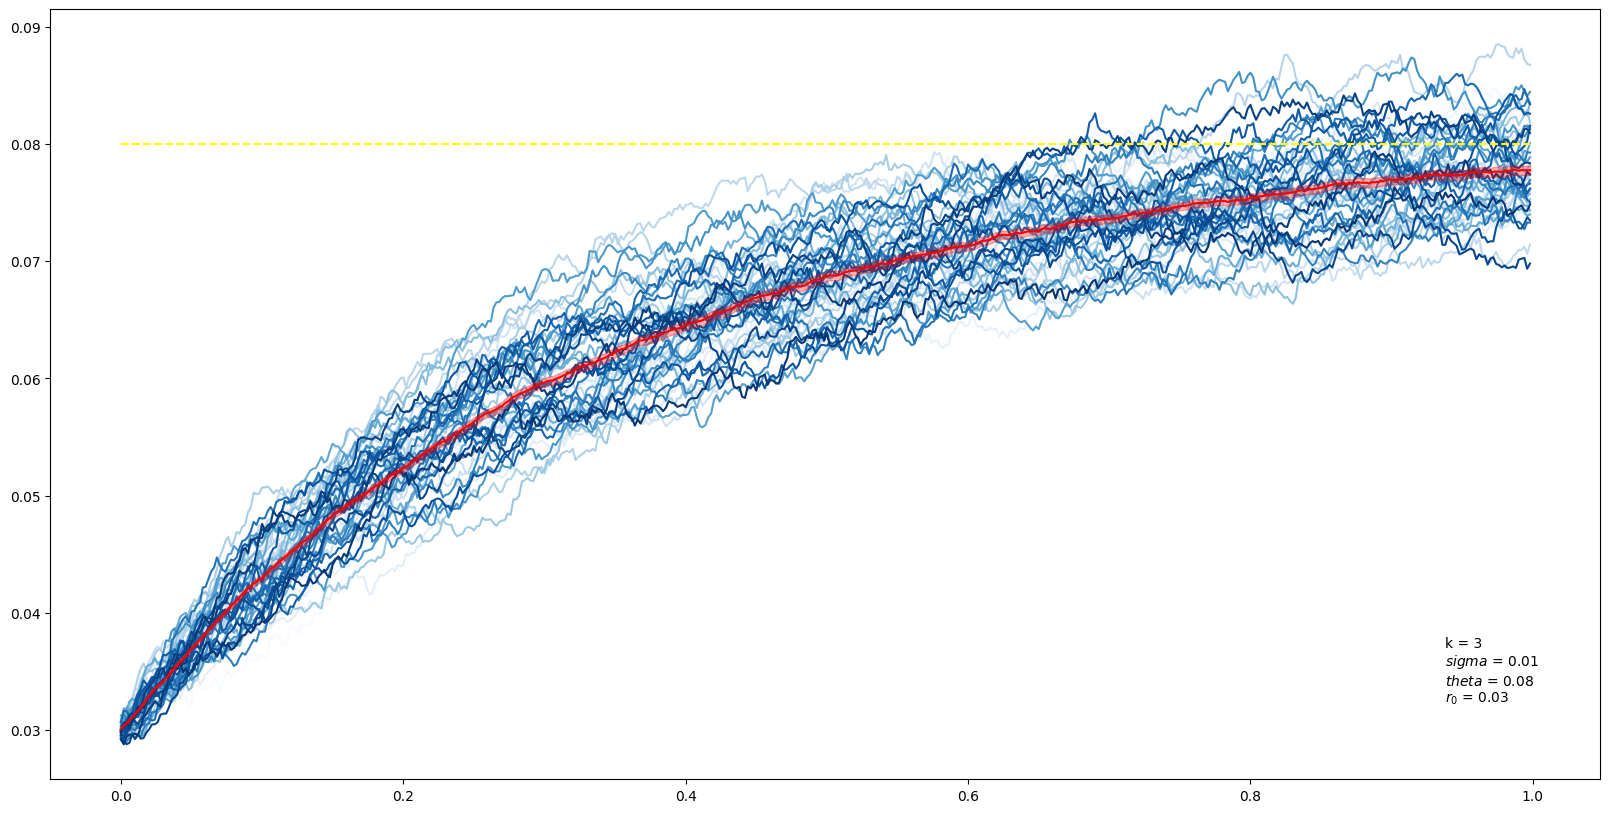

In [50]:
k = 3
sigma = 0.01
theta = 0.08
r0 = 0.03

NPOINTS = 500
NPATH = 100
NDRAW = 50

fig = plt.figure()
ax = fig.add_subplot()

norm = mpl.colors.Normalize(vmin=1, vmax=NDRAW+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

t = np.linspace(0, NPOINTS-1, NPOINTS) / NPOINTS
dt = t[1] - t[0]

dw = np.random.normal(size = (NPOINTS, NPATH)) * np.sqrt(dt) 
expon = np.exp( - k * t).reshape(-1, 1)
rate = r0 * expon + theta * (1 - expon) + sigma * expon * np.cumsum(np.exp(k * t).reshape(-1, 1) * dw, axis=0)

for i in range(NDRAW):
    ax.plot(t, rate[:, i], c = cmap.to_rgba(i + 1))

m = np.mean(rate, axis=1)
s = np.std(rate, axis=1) / np.sqrt(NPATH)

ax.plot(t, m, c='red', label='Mean')
ax.fill_between(t, m + s, m - s, color='red', alpha=0.3, zorder=100)
ax.plot(t, np.ones(NPOINTS) * theta, c='yellow', ls='--')
ax.text(0.9, 0.1, f"k = {k} \n$sigma$ = {sigma}\n$theta$ = {theta}\n$r_0$ = {r0}", transform=ax.transAxes)
fig.savefig('plot/VASICEK.pdf')
plt.show()

### How to perform a calibration

In [55]:
df = pd.read_csv('data/curve.csv')
maturities = df['Maturity'].values
p0 = df['Discount'].values

class Vasicek:
    def __init__(self, p0, maturities, NPATHS=1000):
        self.p0 = p0
        self.maturities = maturities
        self.NPOINTS = int(maturities[-1] * 52)
        self.NPATHS = NPATHS
        
        self.timestructure = np.linspace(0, maturities[-1], self.NPOINTS+1)
        self.dt = self.timestructure[1] - self.timestructure[0]
        dw = np.random.normal(size=(self.NPOINTS, self.NPATHS)) * np.sqrt(self.dt)
        self.dw = np.concatenate((np.zeros((1, NPATHS)), dw), axis=0)
        self.param = None
        self.rate = None
        
    def GetInitialDisc(self, param):
        k, theta, sigma, r0 = param
        b = 1 / k * (1 - np.exp(- k * (self.maturities - 0)))
        a = (theta - sigma**2 / (2 * k**2)) * (b - self.maturities + 0) - sigma ** 2 / (4*k) * b **2
        rval = np.exp(a- b * r0)
        return rval

    def obj_func(self, param):
        disc = self.GetInitialDisc(param)
        return disc - self.p0
    
    def Calibrate(self):
        param0 = [0.01, 0.001, 0.08, 0.03]
        res = least_squares(self.obj_func, param0, verbose=0, bounds=([0, 0, 0, 0], np.inf))
        self.param = res.x
        k, theta, sigma, r0 = self.param
        expon = np.exp(- k * self.timestructure).reshape(-1, 1)
        integral = np.cumsum(np.exp(k * self.timestructure).reshape(-1, 1) * self.dw, axis=0)
        self.rate = r0 * expon + theta * (1 - expon) + sigma * expon * integral
    
    def CurveEvolve(self, t, maturities):
        k, theta, sigma, r0 = self.param
        maturities = np.where(maturities >= t, maturities, t)
        b = 1 / k * (1 - np.exp(- k * (maturities - t))) 
        a = (theta - sigma**2 / (2 * k**2)) * (b - maturities + t) - sigma ** 2 / (4*k) * b **2
        t_index = np.abs(t-self.timestructure).argmin()
        r = self.rate[t_index,:]
        rval = np.exp(a.reshape(-1, 1) - b.reshape(-1, 1) * r)
        return rval

vasicek = Vasicek(p0, maturities)
vasicek.Calibrate()
rate = vasicek.rate

### Evolving the yield curve

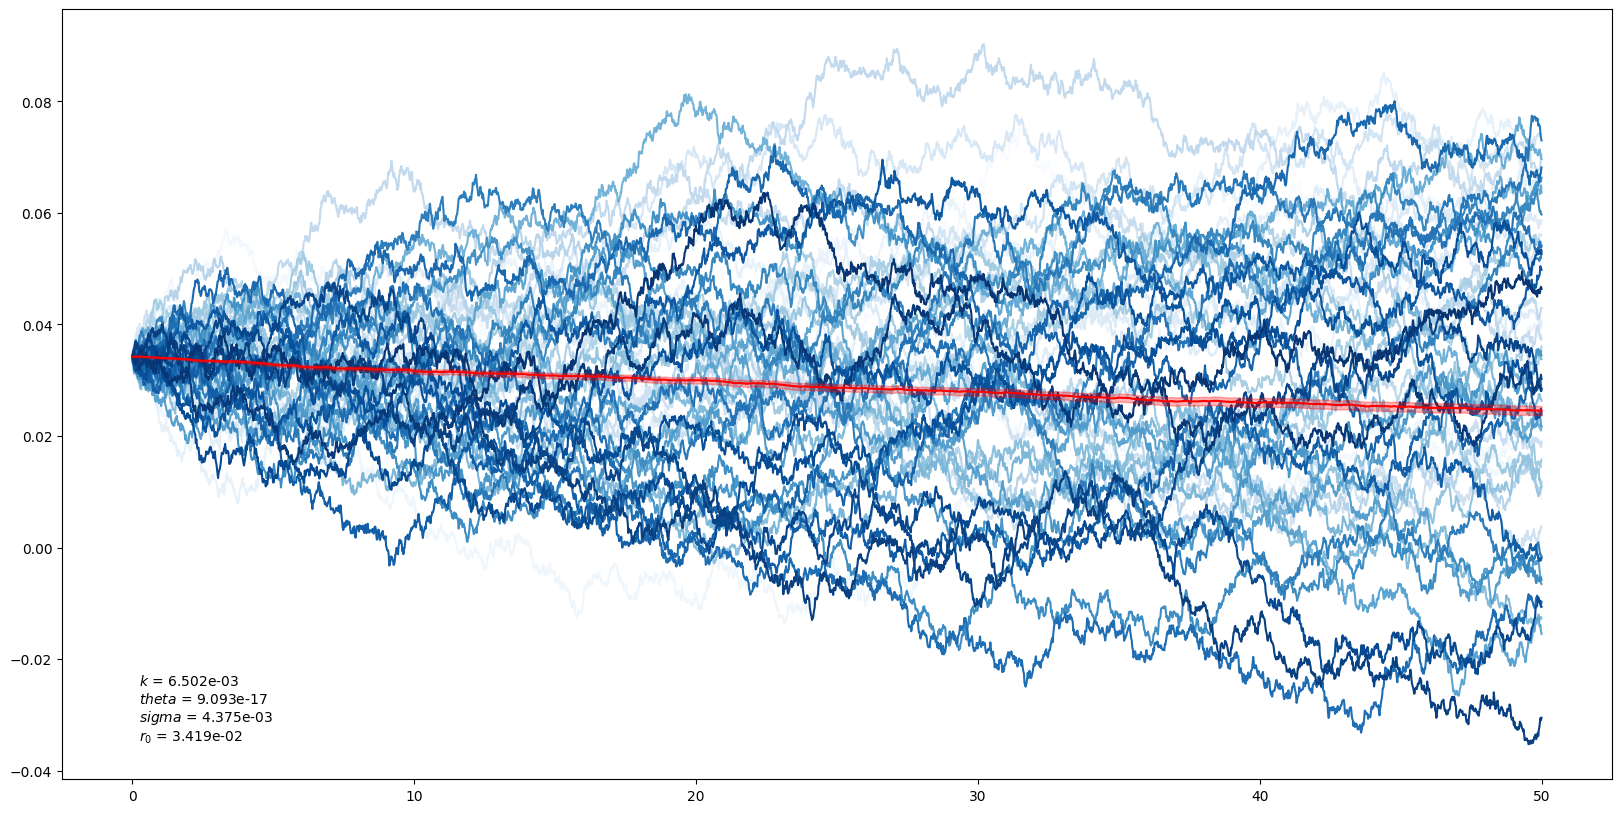

In [56]:
NDRAW = 50

fig = plt.figure()
ax = fig.add_subplot()

norm = mpl.colors.Normalize(vmin=1, vmax=NDRAW+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

t = vasicek.timestructure
k, theta, sigma, r0 = vasicek.param
for i in range(NDRAW):
    ax.plot(t, rate[:, i], c = cmap.to_rgba(i + 1))

m = np.mean(rate, axis=1)
s = np.std(rate, axis=1) / np.sqrt(rate.shape[1])

ax.plot(t, m, c='red', label='Mean')
ax.fill_between(t, m + s, m - s, color='red', alpha=0.3, zorder=100)
ax.text(0.05, 0.05, f"$k$ = {k:.3e}\n$theta$ = {theta:.3e}\n$sigma$ = {sigma:.3e}\n$r_0$ = {r0:.3e}", transform=ax.transAxes)
fig.savefig('plot/VASICEK_CALIBRATION.pdf')
plt.show()

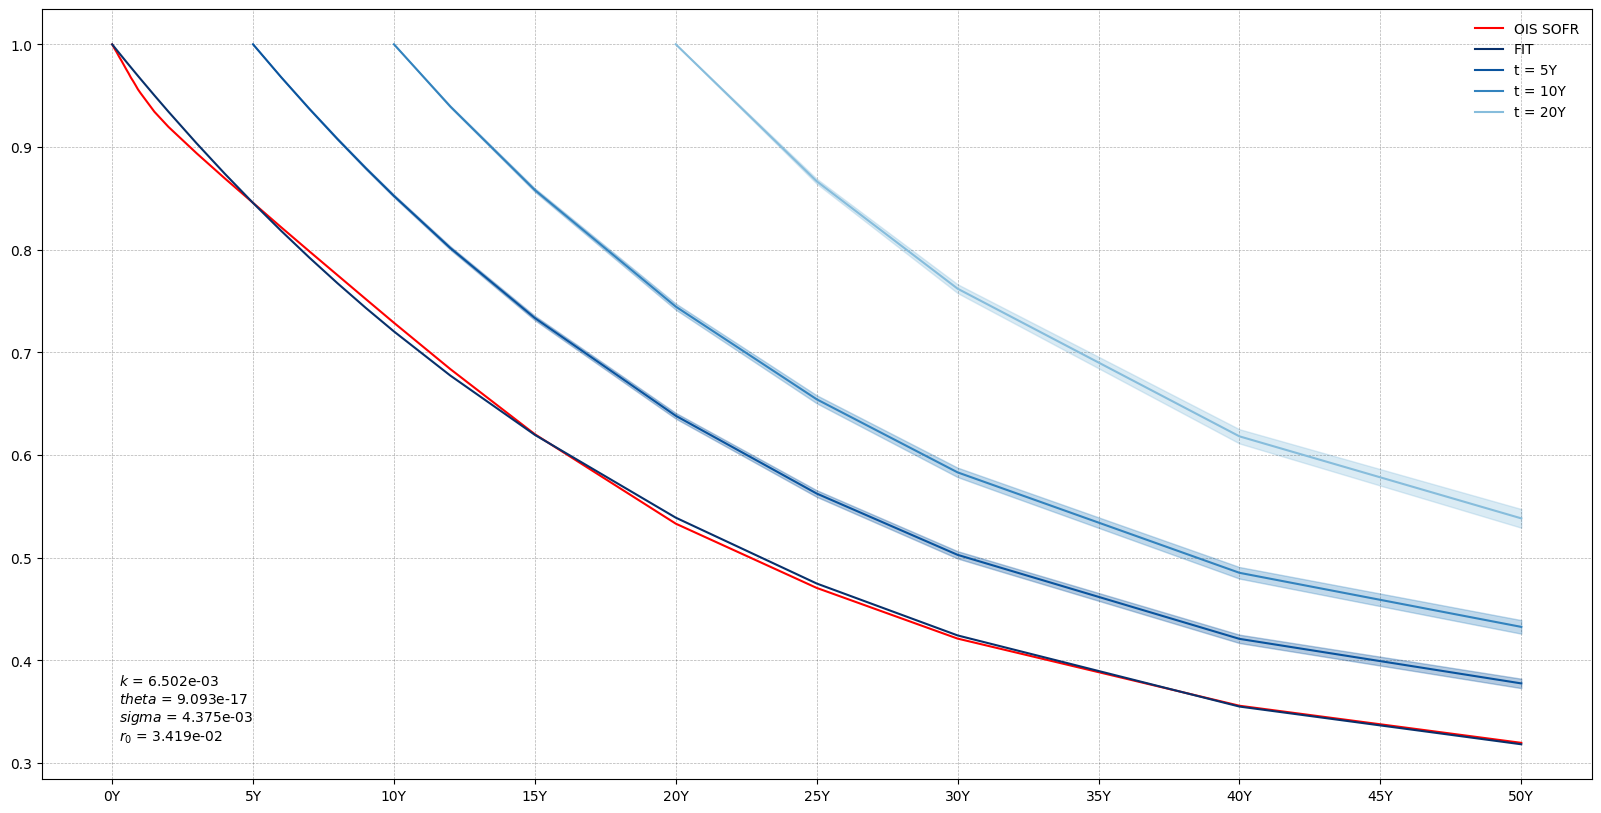

In [57]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(maturities, p0, c='r', label = 'OIS SOFR')

NDRAW = 5
norm = mpl.colors.LogNorm(vmin=1, vmax=NDRAW)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

curve = vasicek.CurveEvolve(0, maturities)
ax.plot(maturities, curve[:, 0], c=cmap.to_rgba(NDRAW), label = 'FIT')
n = curve.shape[1]

for i, t in enumerate([5, 10, 20]):
    idx = np.where(maturities >= t)[0][0]
    curve = vasicek.CurveEvolve(t, maturities)
    mean = np.mean(curve, axis=1)
    std = np.std(curve, axis=1) / np.sqrt(n)
    ax.plot(maturities[idx:], mean[idx:], label = f"t = {t}Y", c=cmap.to_rgba(NDRAW-1-i))
    ax.fill_between(maturities[idx:], mean[idx:] + std[idx:], mean[idx:] - std[idx:], color=cmap.to_rgba(NDRAW-1-i), alpha=0.3)
    
x_ticks = [i * 5 for i in range(0, 11)]
x_ticks_label = [f"{i}Y" for i in x_ticks]

ax.set_xticks(x_ticks, x_ticks_label)
ax.grid(True, ls='--', lw=.5, c='k', alpha=.3)
ax.legend(frameon=False)
ax.text(0.05, 0.05, f"$k$ = {k:.3e}\n$theta$ = {theta:.3e}\n$sigma$ = {sigma:.3e}\n$r_0$ = {r0:.3e}", transform=ax.transAxes)
fig.savefig('plot/VASICEK_CALIBRATION_CURVE.pdf')
plt.show()